# Dependencies

In [34]:
import os
import io
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3 #SDK  
%matplotlib inline

## Data Read

In [35]:
file_path = Path("~/SageMaker/Data/applexy.csv")
features = pd.read_csv(file_path)
x = features["volume"].values.reshape(-1, 1)

In [36]:
y = features["close_"].values.reshape(-1) 

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#print(X_test , X_train)

## Start Modeling and configs 

In [49]:
#print(x , y)
# Define Amazon S3 Bucket to store model data
bucket = "project2part3" 

# Define prefix for data files
prefix = "apple"

# AWS IAM role
role = get_execution_role()

[[ 23913861]
 [ 36930243]
 [ 41666592]
 [ 50424541]
 [ 50037720]
 [ 35003230]
 [ 41357200]
 [ 28601908]
 [ 24205102]
 [ 66119038]
 [ 33861564]
 [ 53259406]
 [ 48162999]
 [ 34380628]
 [ 51328982]
 [ 32661952]
 [ 35055916]
 [ 27690454]
 [ 28511095]
 [ 29736108]
 [ 28106823]
 [ 29274467]
 [ 31418473]
 [ 22564430]
 [ 47913185]
 [ 42751858]
 [ 38299588]
 [ 27645834]
 [ 23046755]
 [ 22579507]
 [ 25911509]
 [ 22251758]
 [ 49253295]
 [ 46561069]
 [ 30313973]
 [ 26107303]
 [ 22582339]
 [ 39534805]
 [ 94392823]
 [ 77041719]
 [ 43405302]
 [ 30498519]
 [ 50640496]
 [ 49511645]
 [ 53100951]
 [ 46976130]
 [ 41486486]
 [ 52521771]
 [ 41393025]
 [ 29891032]
 [ 26420400]
 [ 36391173]
 [ 31740381]
 [ 84526477]
 [ 86492416]
 [ 52874755]
 [ 40753116]
 [ 38888321]
 [ 46908342]
 [225795875]
 [152880540]
 [200393336]
 [257604126]
 [332632509]
 [231598461]
 [176969416]
 [182314907]
 [180861505]
 [140153151]
 [184699355]
 [155049019]
 [177718533]
 [287167821]
 [195769327]
 [183094843]
 [150719279]
 [167744104]

## Create

In [39]:
# Encode the training data as Protocol Buffer
buf = io.BytesIO()
vectors = np.array(X_train).astype("float32")
labels = np.array(y_train).astype("float32")
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

# Upload encoded training data to Amazon S3
key = "linear_train.data"
boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", key)
).upload_fileobj(buf)
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("Training data uploaded to: {}".format(s3_train_data))

Training data uploaded to: s3://project2part3/apple/train/linear_train.data


### Upload Test Data to Amazon S3

In [40]:
# Encode the testing data as Protocol Buffer
buf = io.BytesIO()
vectors = np.array(X_test).astype("float32")
labels = np.array(y_test).astype("float32")
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

# Upload encoded testing data to Amazon S3
key = "linear_test.data"
boto3.resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test", key)
).upload_fileobj(buf)
s3_test_data = "s3://{}/{}/test/{}".format(bucket, prefix, key)
print("Testing data uploaded to: {}".format(s3_test_data))

Testing data uploaded to: s3://project2part3/apple/test/linear_test.data


### Creating instance

In [41]:
# Create an instance of the linear learner algorithm
container = get_image_uri(boto3.Session().region_name, "linear-learner")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [42]:
# Start the Amazon SageMaker session
sess = sagemaker.Session()

# Create an instance of the linear learner estimator
linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)

# Define linear learner hyperparameters
linear.set_hyperparameters(
    feature_dim=1,
    mini_batch_size=100,
    predictor_type="regressor",
    epochs=10,
    num_models=32,
    loss="absolute_loss",
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Training the Machine Learning Model

In [43]:
# Fitting the linear learner model with the training data
linear.fit({"train": s3_train_data, "test": s3_test_data})

2022-01-05 15:36:53 Starting - Starting the training job...
2022-01-05 15:37:17 Starting - Launching requested ML instancesProfilerReport-1641397012: InProgress
......
2022-01-05 15:38:17 Starting - Preparing the instances for training............
2022-01-05 15:40:21 Downloading - Downloading input data...
2022-01-05 15:40:47 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/05/2022 15:40:52 INFO 140482638710592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init

## Deploying the Model to Make Predictions

In [44]:
# An instance of the linear-learner predictor is created
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [45]:
# Linear predictor configurations
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [46]:
# Making some predictions using the test data.
result = linear_predictor.predict(X_test)
y_predictions = np.array([r["score"] for r in result["predictions"]])
y_predictions[:5]

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


array([134.31843567, 148.50961304, 131.76821899, 134.62069702,
       148.47392273])

## Model Evaluation

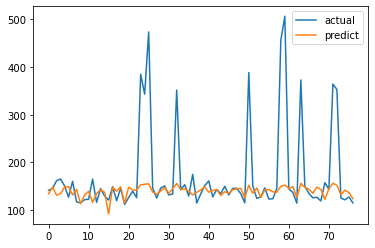

In [47]:
# Plotting predicted Vs. actual values
plt.plot(np.array(y_test), label="actual")
plt.plot(y_predictions, label="predict")
plt.legend()
plt.show()

In [48]:
# Calculating the RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
r2 = r2_score(y_test, y_predictions)

print("RMSE: {}".format(rmse))
print("R2 score: {}".format(r2))

RMSE: 91.8850907309831
R2 score: -0.008155816434425756


## Delete Amazon SageMaker end-point

In [16]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)